# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.


And please, avoid doing that... 👇🏻

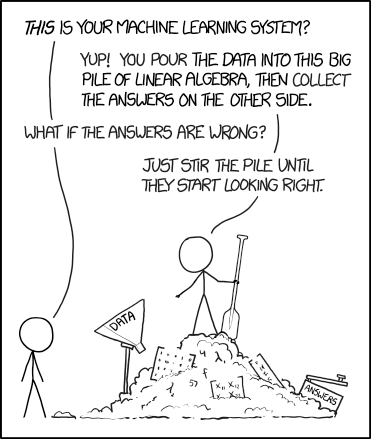

# Solution

## Dataset and utilities

First we import libraries, functions and define the dataset and utility functions.

In [7]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from typing import Union, Tuple
import random
from collections import defaultdict
import time

import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

from sklearn.decomposition import KernelPCA, PCA
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import KernelCenterer

import pickle
import pandas as pd

In [8]:
# Set the random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)  # For PyTorch
# np.random.seed(SEED)  # For NumPy
# random.seed(SEED)  # For Python's random module

# Transformation to data
to_tensor = transforms.ToTensor()

# Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(
    root="./data", train=True,
    transform=transforms.Compose([to_tensor]),
    download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False,
    transform=transforms.Compose([to_tensor]),
    download=True
)

# Calculate the scaled mean and std for normalization
scaled_mean_train = train_dataset.data.float().mean() / 255
scaled_std_train = train_dataset.data.float().std() / 255

print(f"Original images mean and std of the training set: {scaled_mean_train:.2f}, {scaled_std_train:.2f}\n")

# New transformations using training set statistics
normalization = transforms.Normalize(mean=(scaled_mean_train,), std=(scaled_std_train,))

# Normalized datasets
normalized_train_dataset = datasets.FashionMNIST(
    root="./data", train=True,
    transform=transforms.Compose([to_tensor, normalization]),
    download=True
)

normalized_test_dataset = datasets.FashionMNIST(
    root="./data", train=False, 
    transform=transforms.Compose([to_tensor, normalization]),  # Use training set stats for normalization
    download=True
)

# Shuffle the training dataset with a fixed seed
perm = torch.randperm(len(normalized_train_dataset.targets))
normalized_train_dataset.data = normalized_train_dataset.data[perm]
normalized_train_dataset.targets = normalized_train_dataset.targets[perm]

# DATA FOR PCA --------------------------------------------------------------
# Convert the images to a 1D tensor of features and normalize them
train_data = normalized_train_dataset.data.view(len(normalized_train_dataset), -1).float()  # Shape: [samples, features] = [60000, 784]
train_labels = normalized_train_dataset.targets

# We use scikit-learn's PCA implementation and the default parameters assuming that the data is normalized
train_data = train_data.numpy() 
train_data = StandardScaler().fit_transform(train_data)

print(f"PCA Training data mean: {train_data.mean():.2f}, std: {train_data.std():.2f}")

# Define the class names for FashionMNIST
class_to_idx = normalized_train_dataset.class_to_idx
class_names = class_to_idx.keys()
idx_to_class = {v: k for k, v in class_to_idx.items()}

torch.seed()  # Resets PyTorch’s random number generator

Original images mean and std of the training set: 0.29, 0.35

PCA Training data mean: 0.00, std: 1.00


18429999863705278385

In [6]:
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

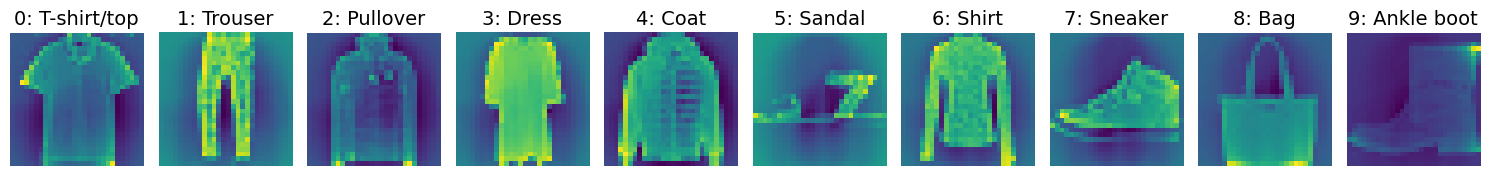

In [9]:
# Function to plot one example of each class
def plot_fashion_mnist_examples(data, labels, class_to_idx, save_fig=True, filename="fashion_mnist_examples.png"):
    # Convert the class indices to class names for display
    idx_to_class = {value: key for key, value in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]
    
    # Dictionary to store one example per class
    class_examples = {class_name: None for class_name in class_names}

    # Find one example of each class
    for i in range(len(labels)):
        label = int(labels[i])  # Ensure the label is an integer
        class_name = idx_to_class[label]
        # Store the first example of each class
        if class_examples[class_name] is None:
            class_examples[class_name] = data[i].reshape(28, 28)  # Reshape to 28x28 image
        
        # Stop iteration if all classes have been captured
        if all(example is not None for example in class_examples.values()):
            break

    # Plot the examples
    num_classes = len(class_names)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))
    for ax, (class_name, image) in zip(axes, class_examples.items()):
        ax.imshow(image, cmap="viridis")  # Plot the image
        ax.set_title(f"{class_to_idx[class_name]}: {class_name}", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    if save_fig:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{filename}", bbox_inches='tight')
    
    plt.show()

# Plot the examples
plot_fashion_mnist_examples(train_data, train_labels, class_to_idx, save_fig=True, filename="fashion_mnist_examples.png")


## Section 1

We are going to leverage the `PCA` and `KernelPCA` classes from `sklearn.decomposition` to perform PCA and Kernel-PCA.

In [10]:
def apply_pca_fashion_mnist(data, skip_samples=None, kernel=None, gamma=None, degree=None, max_components_out=None):
    # Maximum number of components to output: save memory and computation time
    
    if skip_samples is not None:
        data = data[::skip_samples]
    if kernel is None:
        pca = PCA(n_components=max_components_out)
    elif kernel == 'rbf':
        pca = KernelPCA(kernel=kernel, gamma=gamma, n_components=max_components_out)
    elif kernel == 'poly' and degree is not None:
        pca = KernelPCA(kernel='poly', degree=degree, n_components=max_components_out)
    else:
        raise ValueError("Invalid kernel or degree")
    pca_data = pca.fit_transform(data)
    
    # Obs: to output the cumulative explained variance ratio doesn't make too much
    # sense when the number of components is limited to MAX_COMPONENTS_OUT
    # Instead, we can output the explained variance ratio for the first MAX_COMPONENTS_OUT components
    # using an approximation of the total variance in feature space
    
    total_variance = 0
    
    if max_components_out is not None:
        # Center the kernel matrix
        kernel_centerer = KernelCenterer()
        kernel_matrix = None
        
        if kernel == 'rbf':
            kernel_matrix = pairwise_kernels(data, metric='rbf', gamma=gamma)
        elif kernel == 'poly' and degree is not None:
            kernel_matrix = pairwise_kernels(data, metric='poly', degree=degree)
        else:
            raise ValueError("Invalid kernel or degree")
        
        if kernel is None:
            total_variance = np.sum(np.var(data, axis=0))
        elif kernel in ['rbf', 'poly']:
            kernel_matrix_centered = kernel_centerer.fit_transform(kernel_matrix)
            total_variance = np.trace(kernel_matrix_centered)/data.shape[0]
        
        pca_data = pca_data[:, :max_components_out]
    else:
        total_variance = np.var(pca_data, axis=0).sum()
        
    eigenvalues = np.var(pca_data, axis=0)
    cumulative_explained_variance_ratio = np.cumsum(eigenvalues)/total_variance
    
    return pca_data, cumulative_explained_variance_ratio

def apply_tsne_fashion_mnist(data, skip_samples=None, n_components=2, perplexity=30, learning_rate=200, n_iter=1000):
    """
    Perform t-SNE dimensionality reduction on the input data.
    """
    # Subsample data if skip_samples is specified
    if skip_samples is not None:
        data = data[::skip_samples]
    
    # Standardize the data
    data_normalized = StandardScaler().fit_transform(data)
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=n_components, 
        perplexity=perplexity, 
        learning_rate=learning_rate, 
        n_iter=n_iter, 
        random_state=42
    )
    tsne_data = tsne.fit_transform(data_normalized)
    
    return tsne_data

def plot_dimensionality_reduction(data, labels, n_components, class_to_idx, title, pca=True, show_numeric_labels=True, save_fig=False, filename=None):
    
    # Map integer labels to class names using class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    unique_labels = sorted(class_to_idx.values())  # Numeric class labels
    
    fig = plt.figure(figsize=(7, 5) if n_components == 2 else (9, 6))
    ax = None
    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
    elif n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10', s=20, alpha=0.7)
        ax.set_zlabel('PC3' if pca else 't-SNE Dim 3')
    else:
        raise ValueError("n_components must be 2 or 3")
    
    # Add colorbar with class names or numeric labels
    cbar = fig.colorbar(scatter, ax=ax, ticks=unique_labels)
    cbar.set_label('Classes' if not show_numeric_labels else 'Class indices')
    if not show_numeric_labels:
        cbar.ax.set_yticklabels([idx_to_class[idx] for idx in unique_labels])
    else:
        cbar.ax.set_yticklabels(unique_labels)
    
    # Set labels and title
    ax.set_xlabel('PC1' if pca else 't-SNE Dim 1')
    ax.set_ylabel('PC2' if pca else 't-SNE Dim 2')
    ax.set_title(title)
    
    # Save the figure if required
    if save_fig:
        if not filename:
            raise ValueError("Filename must be provided when save_fig is True")
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{filename}.png", dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

    
def plot_explained_variance_ratio(cumulative_explained_variance_ratio, title, save_fig=False, filename=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(1, len(cumulative_explained_variance_ratio) + 1)
    ax.plot(x, cumulative_explained_variance_ratio, marker='o', linestyle='--', markersize=4)
    
    # Compute the elbow point
    knee = KneeLocator(x, cumulative_explained_variance_ratio, curve='concave', direction='increasing')

    # Get the elbow point
    elbow_x = knee.knee
    elbow_y = knee.knee_y
    elbow_index = (np.abs(x - elbow_x)).argmin() # Difference because of floating point precision
    ax.scatter(elbow_x, elbow_y, color='orange', edgecolor='black', s=60, zorder=3, linewidths=2, 
               label=f'Elbow Point: ({elbow_index} comp., {elbow_y:.2f})')
    
    # Do 10 components reflect the knee-point?
    percentage_diff = np.abs((elbow_index - 10) / 10 * 100)
    print(f"Percentage difference between elbow point and 10 components: {percentage_diff:.2f}%")
    
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance ratio')
    ax.set_ylim(0, 1.1)
    ax.set_title(title)
    ax.text(0.9*cumulative_explained_variance_ratio.shape[0], 0.1, f'2 comp. : {cumulative_explained_variance_ratio[1]:.2f}', ha='right', fontsize=12)
    ax.text(0.9*cumulative_explained_variance_ratio.shape[0], 0.2, f'3 comp. : {cumulative_explained_variance_ratio[2]:.2f}', ha='right', fontsize=12)
    ax.text(0.9*cumulative_explained_variance_ratio.shape[0], 0.3, f'10 comp. : {cumulative_explained_variance_ratio[9]:.2f}', ha='right', fontsize=12)
    ax.axhline(y=cumulative_explained_variance_ratio[9], color='r', linestyle='--', label='10 comp.')
    
    plt.legend()
    plt.grid()

    if save_fig:
        if not filename:
            raise ValueError("Filename must be provided when save_fig is True")
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{filename}.png", bbox_inches='tight')
    
    plt.show()

import pickle

def save_dim_reduction_datasets(dataset_dict, filename="dim_reduction_datasets.pkl"):
    os.makedirs("results", exist_ok=True)
    with open(f"results/{filename}", "wb") as f:
        pickle.dump(dataset_dict, f)
def load_dim_reduction_datasets(filename="dim_reduction_datasets.pkl"):
    if not os.path.exists(f"results/{filename}"):
        raise FileNotFoundError(f"File not found: {filename}")
    with open(f"results/{filename}", "rb") as f:
        return pickle.load(f)


In [11]:
SKIP_SAMPLES = 5
DIMENSIONS = 10  # Number of dimensions to keep

# Define dimensionality reduction datasets
dim_reduction_datasets = {}

Percentage difference between elbow point and 10 components: 850.00%


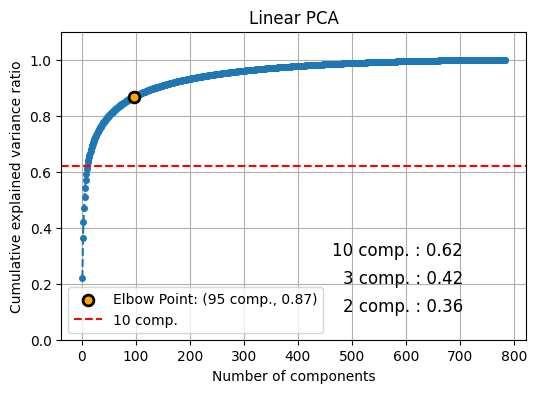

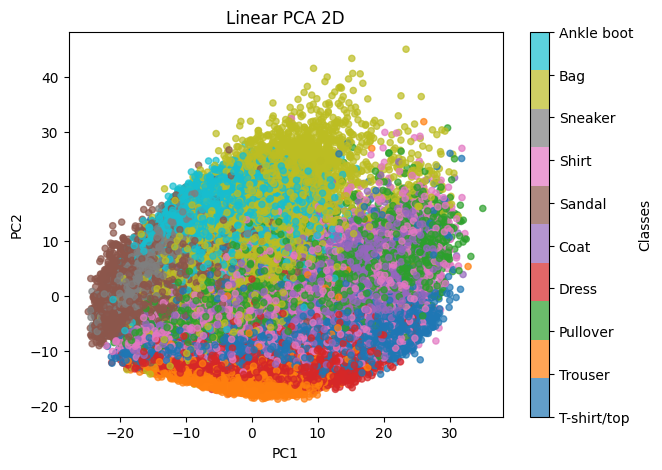

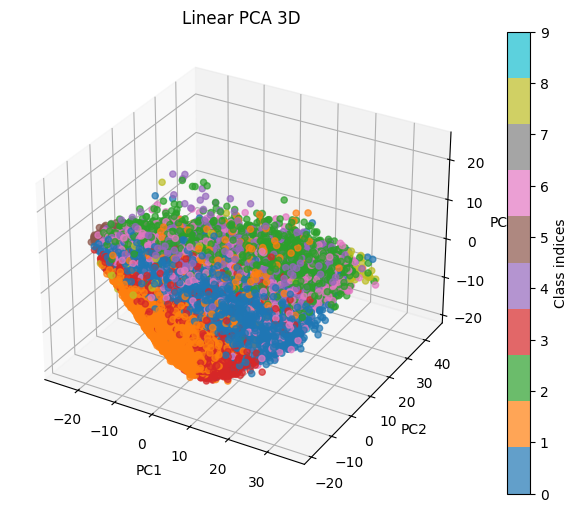

CPU times: user 35 s, sys: 2.3 s, total: 37.3 s
Wall time: 11 s


In [12]:
%%time 

SKIP_SAMPLES = 5
DIMENSIONS = 10  # Number of dimensions to keep

# Define dimensionality reduction datasets
dim_reduction_datasets = {}

linear_pca_data, linear_explained_var = apply_pca_fashion_mnist(data=train_data)
plot_explained_variance_ratio(linear_explained_var,
                              title="Linear PCA",
                              save_fig=True,
                              filename="linear_pca_explained_variance_ratio")
plot_dimensionality_reduction(
        linear_pca_data,
        train_labels,
        n_components=2,
        class_to_idx=class_to_idx,
        show_numeric_labels=False,
        title="Linear PCA 2D",
        save_fig=True,
        filename="linear_pca_2d")
plot_dimensionality_reduction(
        linear_pca_data,
        train_labels,
        n_components=3,
        class_to_idx=class_to_idx, 
        title="Linear PCA 3D",
        save_fig=True,
        filename="linear_pca_3d")

dim_reduction_datasets["Linear PCA"] = linear_pca_data[:, :DIMENSIONS]
save_dim_reduction_datasets(dim_reduction_datasets)

In [ ]:
%%time 

# Estimate gamma for kernels
X = train_data[::SKIP_SAMPLES]

# Compute Gram matrix
G = np.dot(X, X.T)

# Extract squared norms of each point
v = np.diag(G)

# Compute squared distances
D = v[:, None] + v[None, :] - 2 * G

# Estimate gamma
gamma = 1 / np.mean(D)

print(f"Estimated gamma with inverse of mean squared differences: {gamma:.4e}")
print(f"Estimated gamma with inverse of features number: {1/X.shape[1]:.4f}")
print(f"Estimated gamma with the inverse of the variance of the data: {0.5/np.var(X):.4f}") # should be ~0.5 because the data is normalized
print(f"Estimated gamma with the inverse of variance and features number: {1/(X.shape[1]*np.var(X)):.4f}")

# Maximum and minimum values of the dot product
max_dot_product = np.max(G)
min_dot_product = np.min(G)
print(f"Maximum dot product: {max_dot_product:.2f}, minimum dot product: {min_dot_product:.2f}")


In [ ]:
%%time 

gamma_rbf_list = [10, 1, 0.1, 0.01, 0.001]

for gamma in gamma_rbf_list:
    start_time = time.time()
    
    gaussian_pca_data, gaussian_explained_var = apply_pca_fashion_mnist(
        data=train_data, skip_samples=SKIP_SAMPLES, kernel='rbf', gamma=gamma,
    )
    plot_explained_variance_ratio(gaussian_explained_var,
                                title=rf"Gaussian Kernel PCA $\gamma=${gamma}",
                                save_fig=True,
                                filename=f"gaussian_pca_explained_variance_ratio_gamma-{gamma}")
    plot_dimensionality_reduction(
            gaussian_pca_data,
            train_labels[::SKIP_SAMPLES],
            n_components=2,
            class_to_idx=class_to_idx,
            title=rf"Gaussian Kernel PCA 2D $\gamma=${gamma}",
            save_fig=True,
            filename=f"gaussian_pca_2d_gamma-{gamma}")
    plot_dimensionality_reduction(
            gaussian_pca_data,
            train_labels[::SKIP_SAMPLES],
            n_components=3,
            class_to_idx=class_to_idx, 
            title=rf"Gaussian Kernel PCA 3D $\gamma=${gamma}",
            save_fig=True,
            filename=f"gaussian_pca_3d_gamma-{gamma}")
    dim_reduction_datasets[f"Gaussian_PCA_gamma-{gamma}"] = gaussian_pca_data[:, :DIMENSIONS]
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"Elapsed time for gamma={gamma}: {elapsed_time:.2f} minutes")
    
save_dim_reduction_datasets(dim_reduction_datasets)

In [ ]:
%%time

degrees_list = [2, 3, 4]

for degree in degrees_list:
    start_time = time.time()

    poly_pca_data, poly_explained_var = apply_pca_fashion_mnist(
        data=train_data, skip_samples=SKIP_SAMPLES, kernel='poly', degree=degree
    )
    plot_explained_variance_ratio(poly_explained_var,
                                title=f"Polynomial Kernel PCA (n={degree})",
                                save_fig=True,
                                filename=f"poly_pca_explained_variance_ratio_degree{degree}")
    plot_dimensionality_reduction(
            poly_pca_data,
            train_labels[::SKIP_SAMPLES],
            n_components=2,
            class_to_idx=class_to_idx,
            title=f"Polynomial (n={degree}) Kernel PCA 2D",
            save_fig=True,
            filename=f"poly_pca_2d_degree{degree}")
    plot_dimensionality_reduction(
            poly_pca_data,
            train_labels[::SKIP_SAMPLES],
            n_components=3,
            class_to_idx=class_to_idx, 
            title=f"Polynomial (n={degree}) Kernel PCA 3D",
            save_fig=True,
            filename=f"poly_pca_3d_degree{degree}")
    
    dim_reduction_datasets[f"Polynomial_PCA_degree-{degree}"] = poly_pca_data[:, :DIMENSIONS]
    
    elapsed_time = (time.time() - start_time) / 60
    print(f"Elapsed time for degree={degree}: {elapsed_time:.2f} minutes")
    
save_dim_reduction_datasets(dim_reduction_datasets)

In [ ]:
%%time 

tsne_data = None

# Apply t-SNE
for n_components in [2, 3]:

    tsne_data = apply_tsne_fashion_mnist(
        data=train_data, 
        skip_samples=SKIP_SAMPLES, 
        n_components=n_components, 
        perplexity=50, 
        learning_rate=200, 
        n_iter=1000
    )

    # Plot the t-SNE data with class names in the colorbar
    plot_dimensionality_reduction(
        data=tsne_data, 
        labels=train_labels[::SKIP_SAMPLES], 
        n_components=n_components, 
        title=f"t-SNE {n_components}D", 
        class_to_idx=class_to_idx,
        pca=False,
        show_numeric_labels=True, # Set True to display numeric labels instead of class names
        save_fig=True,
        filename=f"tsne_{n_components}d"
    )
    
    dim_reduction_datasets[f"tsne_{n_components}D"] = tsne_data

## Section 2


Clustering using KMeans...
Processing Linear PCA...


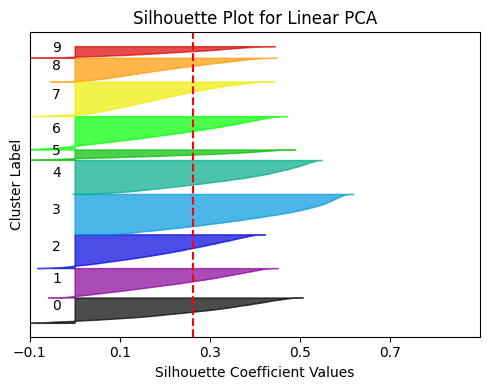

Kernel: Linear PCA, Adjusted Rand Index: 0.37, Silhouette Score: 0.26, Silhouette Score (Ground Truth): 0.07

Clustering using Agglomerative Clustering...
Processing Linear PCA...


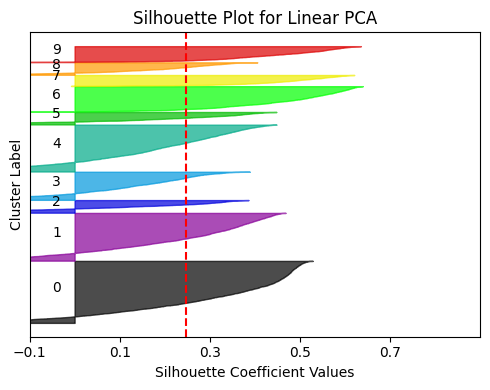

Kernel: Linear PCA, Adjusted Rand Index: 0.34, Silhouette Score: 0.25, Silhouette Score (Ground Truth): 0.07


In [13]:
%%time 

N_CLUSTERS = 10  # Number of clusters

clustering_results = {}

# Loop over clustering methods
for method in ['KMeans', 'Agglomerative Clustering']:
    print(f"\nClustering using {method}...")
    
    results = {}

    # Loop over datasets
    for kernel, dataset in dim_reduction_datasets.items():
        print(f"Processing {kernel}...")
        
        # Initialize the clustering algorithm
        if method == 'KMeans':
            clustering = KMeans(n_clusters=N_CLUSTERS, random_state=42)
        else:
            clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='ward')
            # Subsample for Agglomerative Clustering with Linear PCA
            dataset = dataset[::SKIP_SAMPLES] if kernel == 'Linear PCA' else dataset

        # Predict cluster labels
        cluster_labels = clustering.fit_predict(dataset)
        
        # Get ground truth labels
        ground_truth_labels = (
            train_labels if kernel == 'Linear PCA' else train_labels[::SKIP_SAMPLES]
        ) if method == 'KMeans' else train_labels[::SKIP_SAMPLES]
        
        # Evaluate clustering
        ari = adjusted_rand_score(ground_truth_labels, cluster_labels)
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        silhouette_ground_truth = silhouette_score(dataset, ground_truth_labels)
        results[kernel] = [ari, silhouette_avg, silhouette_ground_truth, cluster_labels]

        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

        # Create silhouette plot
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))  # (width, height)
        y_lower = 10  # Starting point for silhouette plot

        for i in range(N_CLUSTERS):
            # Aggregate silhouette scores for samples belonging to cluster i
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Choose a color for the cluster
            color = cm.nipy_spectral(float(i) / N_CLUSTERS)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label silhouette plots with cluster numbers
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Update y_lower for next cluster
            y_lower = y_upper + 10  # Add space between clusters

        # Add titles and labels to the silhouette plot
        ax.set_title(f"Silhouette Plot for {kernel}")
        ax.set_xlabel("Silhouette Coefficient Values")
        ax.set_ylabel("Cluster Label")

        # Vertical line for average silhouette score
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])  # Clear y-axis labels
        ax.set_xticks(np.arange(-0.1, 0.9, 0.2))  # Set x-ticks (changed limit to 0.9)
        ax.set_xlim([-0.1, 0.9])  # Set x-axis limit (changed from 1.1 to 0.9)

        # Show and save the plot
        plt.tight_layout()
        plt.savefig(f"figures/silhouette_plot_{kernel}.png", bbox_inches='tight')
        plt.show()

    clustering_results[method] = results
    
    # Print final results for all kernels
    for kernel, metrics in results.items():
        print((
            f"Kernel: {kernel}, "
            f"Adjusted Rand Index: {metrics[0]:.2f}, "
            f"Silhouette Score: {metrics[1]:.2f}, "
            f"Silhouette Score (Ground Truth): {metrics[2]:.2f}"
        ))


os.makedirs("results", exist_ok=True)
with open("results/clustering_results.pkl", "wb") as f:
    pickle.dump(clustering_results, f)

In [14]:
with open('results/clustering_results.pkl', 'rb') as file:
    clustering_results = pickle.load(file)

data = []
for method, results in clustering_results.items():
    for kernel, metrics in results.items():
        data.append({
            "Clustering Method": method,
            "Kernel": kernel,
            "Adjusted Rand Index": metrics[0],
            "Silhouette Score": metrics[1],
            "Silhouette Score (Ground Truth)": metrics[2],
            "Clustering Quality": metrics[0] + metrics[1] - np.abs(metrics[2])
        })

df = pd.DataFrame(data)
print(df)
# Save df
df.to_csv("results/clustering_results.csv", index=False)

# Find the method with the best clustering quality
max_quality_index = df["Clustering Quality"].idxmax()

best_method, best_kernel = df.loc[max_quality_index, ["Clustering Method", "Kernel"]]
print(f"\nBest method: {best_method}, Best kernel: {best_kernel}")

# Extract the cluster labels from the best method and kernel
cluster_labels = clustering_results[best_method][best_kernel][3]
skip_samples_cluster = SKIP_SAMPLES if ((best_method == 'KMeans' and best_kernel != 'Linear PCA') \
    or (best_method == 'Agglomerative Clustering'))  else 1

print(f"Cluster labels shape: {cluster_labels.shape}")
print(f"Skip samples for cluster labels: {skip_samples_cluster}")

          Clustering Method      Kernel  Adjusted Rand Index  \
0                    KMeans  Linear PCA             0.371928   
1  Agglomerative Clustering  Linear PCA             0.343867   

   Silhouette Score  Silhouette Score (Ground Truth)  Clustering Quality  
0          0.262206                         0.070308            0.563827  
1          0.247020                         0.068466            0.522421  

Best method: KMeans, Best kernel: Linear PCA
Cluster labels shape: (60000,)
Skip samples for cluster labels: 1


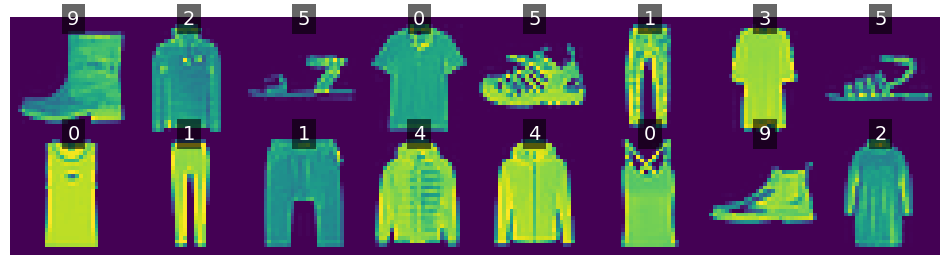

In [15]:
# Function to display images with labels
def imshow_with_labels(images, labels, cmap="viridis"):
    # Add a channel dimension if missing to make the grid
    images = images.unsqueeze(1).float()

    # Make a grid of images
    grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2)
    npimg = grid_img.numpy()

    # Remove the channel dimension (if present)
    npimg = npimg[0]  # Convert to 2D array for grayscale data

    # Plot the images with the specified colormap
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(npimg, cmap=cmap)
    ax.axis("off")

    # Add labels with emojis above each image
    n_images = images.size(0)  # Number of images in the batch
    nrow = 8  # Number of images per row in the grid
    img_size = images.size(2) + 2  # Adjust based on padding
    for i in range(n_images):
        row = i // nrow
        col = i % nrow
        x_pos = col * img_size + img_size // 2 + 1
        y_pos = row * img_size
        # Ensure emoji is properly rendered
        label_text = f"{str(labels[i].item())}"
        ax.text(
            x_pos, y_pos, label_text,
            color="white",
            fontsize=14,
            ha="center",
            va="center",
            bbox=dict(facecolor="black", alpha=0.6, edgecolor="none"),
        )

    plt.show()

# Example usage
images = normalized_train_dataset.data[:16]  
labels = normalized_train_dataset.targets[:16]
imshow_with_labels(images, labels, cmap="viridis")


In [16]:
def manual_labelling(dataset, cluster_labels, skip_samples_cluster=1, class_names=None):
    # Validate inputs
    if class_names is None or len(class_names) == 0:
        raise ValueError("class_names must be a non-empty list of class names.")

    # Subsample the dataset
    dataset = dataset[::skip_samples_cluster]
    cluster_labels = np.array(cluster_labels)
    unique_labels = np.unique(cluster_labels)
    available_labels = list(unique_labels)

    # Prepare the TensorDataset and DataLoader
    tensor_dataset = TensorDataset(dataset.float(), torch.tensor(cluster_labels))
    loader = DataLoader(tensor_dataset, batch_size=32)

    # Initialize class-to-label mapping and available classes
    classes_to_label_number = {class_name: None for class_name in class_names}
    available_classes = list(class_names)

    def display_classes():
        """Display the remaining available classes."""
        print("\nAvailable classes remaining:")
        for idx, class_name in enumerate(available_classes, start=0):
            print(f"{idx}. {class_name}")
        print(f"Available lables: {available_labels}")

    def ask_for_classes(labels):
        while True:
            # Get user input
            user_input = input("Enter class assignment as 'class_index,label_index' or '-1' to skip batch: ")
            if user_input.strip() == "-1":
                print("Skipping this batch.")
                break

            try:
                # Parse and validate input
                class_idx, label_idx = map(int, user_input.split(","))
                if label_idx not in unique_labels:
                    print("Invalid label index. Please select a valid number.")
                    continue
                if not (0 <= class_idx < len(available_classes)):
                    print("Invalid class index. Please select a valid number.")
                    continue
                if classes_to_label_number[available_classes[class_idx]] is not None:
                    print(f"'{available_classes[class_idx]}' has already been assigned.")
                    continue
                if label_idx in classes_to_label_number.values():
                    print(f"Label '{label_idx}' has already been assigned.")
                    continue

                # Assign class to label
                class_name = available_classes.pop(class_idx)
                classes_to_label_number[class_name] = label_idx
                available_labels.remove(label_idx)
                print(f"\nAssigned '{class_name}' to label '{label_idx}'.")
            except ValueError:
                print("Invalid input format. Use 'class_index,label_index' or '-1'.")
                continue
            
            # Exit if no more available classes
            if not available_classes:
                print("All classes have been assigned.")
                break
            # If just one class is remaining assing the remaining label
            elif len(available_classes) == 1:
                print(f"\nAssigning remaining class '{available_classes[0]}' to label '{available_labels[0]}'.")
                classes_to_label_number[available_classes[0]] = available_labels[0]
                available_classes.pop()
                available_labels.pop()
                break
            else:
                display_classes()

    # Process dataset in batches
    for batch_idx, (data, labels) in enumerate(loader):
        print(f"\nProcessing batch {batch_idx + 1}. Assign classes to labels...")
        
        display_classes()
    
        # Display images with labels
        imshow_with_labels(data, labels)

        # Ask for class assignments
        if available_classes:
            ask_for_classes(labels)
        else:
            print("All classes have been assigned. Stopping.")
            break

    # Final output
    print("\nManual labelling complete.")
    
    return classes_to_label_number

def transform_indices(original_indices, original_class_to_idx, new_class_to_idx):
    # Create a reverse mapping of original_class_to_idx to map indices back to their classes
    idx_to_class = {v: k for k, v in original_class_to_idx.items()}
    
    # Transform the original indices to the new indices using the new mapping
    new_indices = [new_class_to_idx[idx_to_class[idx]] for idx in original_indices]
    
    return new_indices


Processing batch 1. Assign classes to labels...

Available classes remaining:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot
Available lables: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


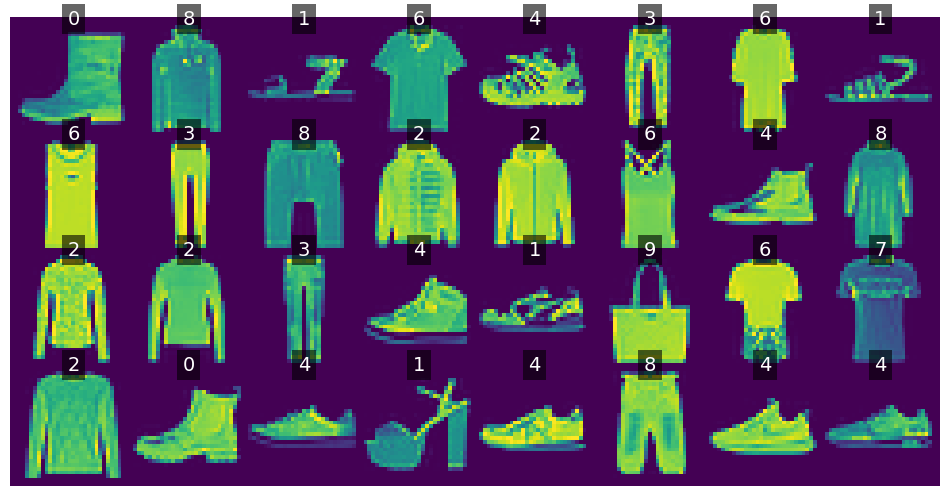


Assigned 'T-shirt/top' to label '6'.

Available classes remaining:
0. Trouser
1. Pullover
2. Dress
3. Coat
4. Sandal
5. Shirt
6. Sneaker
7. Bag
8. Ankle boot
Available lables: [0, 1, 2, 3, 4, 5, 7, 8, 9]

Assigned 'Sandal' to label '1'.

Available classes remaining:
0. Trouser
1. Pullover
2. Dress
3. Coat
4. Shirt
5. Sneaker
6. Bag
7. Ankle boot
Available lables: [0, 2, 3, 4, 5, 7, 8, 9]

Assigned 'Pullover' to label '2'.

Available classes remaining:
0. Trouser
1. Dress
2. Coat
3. Shirt
4. Sneaker
5. Bag
6. Ankle boot
Available lables: [0, 3, 4, 5, 7, 8, 9]

Assigned 'Trouser' to label '8'.

Available classes remaining:
0. Dress
1. Coat
2. Shirt
3. Sneaker
4. Bag
5. Ankle boot
Available lables: [0, 3, 4, 5, 7, 9]
Label '2' has already been assigned.

Assigned 'Shirt' to label '7'.

Available classes remaining:
0. Dress
1. Coat
2. Sneaker
3. Bag
4. Ankle boot
Available lables: [0, 3, 4, 5, 9]

Assigned 'Sneaker' to label '4'.

Available classes remaining:
0. Dress
1. Coat
2. Bag
3. An

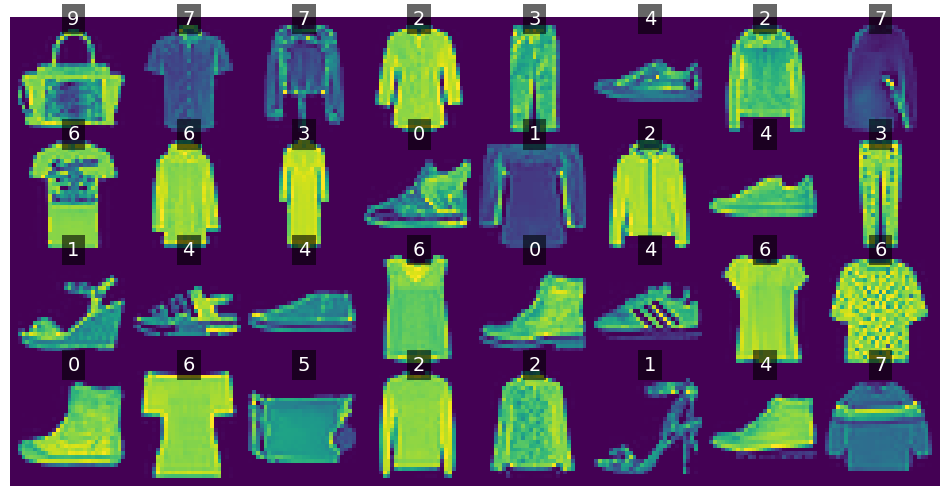

Label '2' has already been assigned.

Assigned 'Dress' to label '3'.

Available classes remaining:
0. Coat
Available lables: [5]

Assigned 'Coat' to label '5'.
All classes have been assigned.

Processing batch 3. Assign classes to labels...

Available classes remaining:
Available lables: []


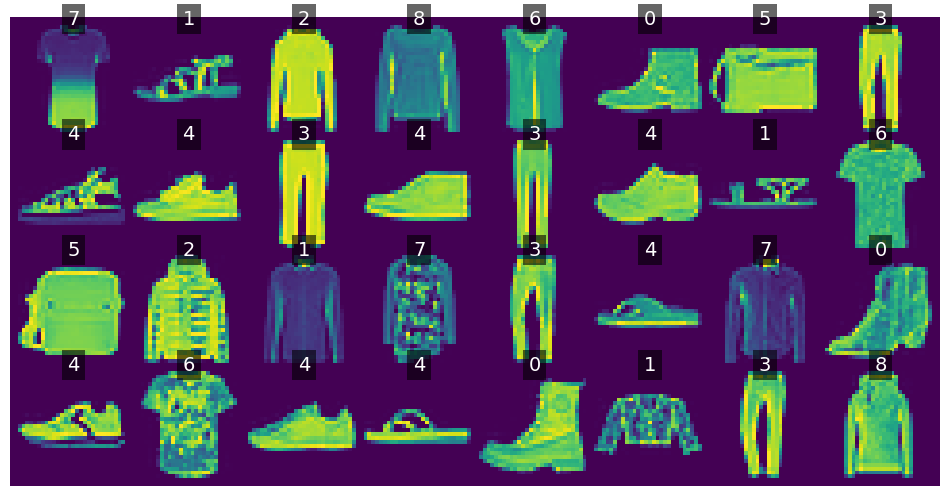

All classes have been assigned. Stopping.

Manual labelling complete.

Class-to-Label Mapping:
T-shirt/top: 6
Trouser: 8
Pullover: 2
Dress: 3
Coat: 5
Sandal: 1
Shirt: 7
Sneaker: 4
Bag: 9
Ankle boot: 0


In [17]:
new_class_to_idx = manual_labelling(
    normalized_train_dataset.data,
    cluster_labels,
    skip_samples_cluster=skip_samples_cluster,
    class_names=class_names,
)

In [ ]:
print("\nClass-to-Label Mapping:")
for class_name, label_number in new_class_to_idx.items():
    print(f"{class_name}: {label_number}")

## Section 3

In [12]:
def get_data(
    train_data: torch.Tensor,
    train_labels: torch.Tensor,
    test_data: torch.Tensor,
    test_labels: torch.Tensor,
    batch_size: int = 32,
    dataloaders: bool = True, 
    best_kernel: str = 'Linear PCA', 
    best_method: str = 'KMeans', 
    skip_samples: int = 5
) -> Union[Tuple[DataLoader, DataLoader], Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    if best_method == 'KMeans' and best_kernel != 'Linear PCA':
        train_data = train_data[::skip_samples]
    elif best_method == 'Agglomerative Clustering':
        train_data = train_data[::skip_samples]
    else:
        pass 
        
    if dataloaders:

        # Create TensorDataset
        train_dataset = TensorDataset(train_data, train_labels)
        test_dataset = TensorDataset(test_data, test_labels)

        # Create DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        return train_loader, test_loader
    else:
        # Convert to numpy arrays
        X_train = train_data.view(train_data.size(0), -1).detach().cpu().numpy()
        X_test = test_data.view(test_data.size(0), -1).detach().cpu().numpy()
        y_train = train_labels.detach().cpu().numpy()
        y_test = test_labels.detach().cpu().numpy()

        return X_train, y_train, X_test, y_test

In [13]:
def svm_classification(X_train, y_train, X_test, y_test, kernel='rbf', C=1.0, gamma='scale', save_fig=False, filename=None):
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape='ovr', random_state=42)
    
    # Train SVM
    svm_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = svm_classifier.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title("Confusion Matrix")
    if save_fig:
        if not filename:
            raise ValueError("Filename must be provided when save_fig is True")
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy

class FCN_classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN_classifier(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) # 1x28x28 -> 32x28x28
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 32x28x28 -> 64x28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 64x28x28 -> 64x14x14
        self.fc1 = nn.Linear(64 * 14 * 14, 128) # 64x14x14 -> 128
        self.fc2 = nn.Linear(128, output_dim) # 128 -> 10
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Dropout layer
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten the tensor for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def nn_classification(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    
    # Model training
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            logits = model(data)
            loss = criterion(logits, target)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()
            
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
    # Model test
    model.eval()
    correct_predictions = 0
    total_test_samples = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            _, predicted_indices = torch.max(logits, 1)
            correct_predictions += (predicted_indices == target).sum().item() 
            total_test_samples += target.size(0)
            
    return train_losses, correct_predictions / total_test_samples

def plot_loss(train_loss, title, save_fig=False, filename=None):
    plt.plot(train_loss, label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title)
    if save_fig:
        if not filename:
            raise ValueError("Filename must be provided when save_fig is True")
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [14]:

def pipeline(train_data, train_labels, test_data, test_labels, real_labels=False,
             skip_samples=5, best_kernel='Linear PCA', best_method='KMeans'):

    # SMV classification-----------------------------------------------------
    X_train, y_train, X_test, y_test = get_data(
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        dataloaders=False, 
        best_kernel=best_kernel,
        best_method=best_method,
        skip_samples=skip_samples
    )

    svm_accuracy = svm_classification(
        X_train, y_train, X_test, y_test,
        kernel='rbf', C=1.0, gamma='scale',
        save_fig=True, filename="svm_confusion_matrix" + ("_real_labels" if real_labels else "")
    )
    print(f"SVM accuracy: {svm_accuracy:.4f}")

    # NN classification------------------------------------------------------
    # Hyperparameters, parameters, loss function, data and device
    LEARNING_RATE = 0.001
    EPOCHS = 10
    BATCH_SIZE = 32
    criterion = nn.CrossEntropyLoss()
    train_loader, test_loader = get_data(
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        batch_size=BATCH_SIZE, 
        dataloaders=True,
    )
    input_dim_fcn = 28*28
    hidden_dim = 64
    output_dim = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # FCN model and optimizer
    fcn_model = FCN_classifier(input_dim_fcn, hidden_dim, output_dim).to(device)
    optimizer = optim.Adam(fcn_model.parameters(), lr=LEARNING_RATE)
    fcn_losses, fcn_accuracy = nn_classification(
        fcn_model, train_loader, test_loader, criterion, optimizer, EPOCHS, device,
    )
    print(f"FCN Testing accuracy: {fcn_accuracy:.4f}")
    plot_loss(fcn_losses, title="FCN Training Loss",
              save_fig=True, filename="fcn_training_loss" + ("_real_labels" if real_labels else ""))

    # CNN model and optimizer
    cnn_model = CNN_classifier(output_dim).to(device)
    optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
    cnn_losses, cnn_accuracy = nn_classification(
        cnn_model, train_loader, test_loader, criterion, optimizer, EPOCHS, device,
        
    )
    print(f"CNN Testing accuracy: {cnn_accuracy:.4f}")
    plot_loss(cnn_losses, title="CNN Training Loss",
              save_fig=True, filename=f"cnn_training_loss" + ("_real_labels" if real_labels else ""))

# Section 4

In [ ]:
# Map the cluster labels to the original class indices to use the real labels for the test set
custom_labels = transform_indices(
    original_indices=cluster_labels, 
    original_class_to_idx=new_class_to_idx,
    new_class_to_idx=class_to_idx
)

pipeline(train_data=normalized_train_dataset.data,
         train_labels=custom_labels,
         test_data=normalized_test_dataset.data,
         test_labels=normalized_test_dataset.targets,
         real_labels=False,
         skip_samples=SKIP_SAMPLES,
         best_kernel=best_kernel,
         best_method=best_method
)

# Section 5

In [ ]:
pipeline(train_data=normalized_train_dataset.data,
         train_labels=normalized_train_dataset.targets,
         test_data=normalized_test_dataset.data,
         test_labels=normalized_test_dataset.targets,
         real_labels=True, 
)

# Section 6

In [ ]:
dim_reduction_datasets = load_dim_reduction_datasets()

tsne_data = dim_reduction_datasets["tsne_3D"]

new_class_to_idx = manual_labelling(
    normalized_train_dataset.data,
    cluster_labels,
    skip_samples_cluster=SKIP_SAMPLES,
    class_names=class_names,
)

In [ ]:
print("\nClass-to-Label Mapping:")
for class_name, label_number in new_class_to_idx.items():
    print(f"{class_name}: {label_number}")

In [ ]:
# Map the cluster labels to the original class indices to use the real labels for the test set
custom_labels = transform_indices(
    original_indices=cluster_labels, 
    original_class_to_idx=new_class_to_idx,
    new_class_to_idx=class_to_idx
)

pipeline(train_data=normalized_train_dataset.data,
         train_labels=custom_labels,
         test_data=normalized_test_dataset.data,
         test_labels=normalized_test_dataset.targets,
         real_labels=False,
         skip_samples=SKIP_SAMPLES,
         best_kernel=best_kernel,
         best_method=best_method
)